In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.metrics import auc, roc_curve, classification_report


from h2o.estimators.glm import H2OGeneralizedLinearEstimator


%matplotlib inline

### Load Data

In [2]:
df_email = pd.read_csv('email_table.csv')
print("if it's true, this table doesnt includes duplicates in ID -->",df_email.shape[0] == df_email['email_id'].nunique())
df_email.head()


if it's true, this table doesnt includes duplicates in ID --> True


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
df_email_open = pd.read_csv('email_opened_table.csv')
print("if it's true, this table doesnt includes duplicates in ID -->",df_email_open.shape[0] == df_email_open['email_id'].nunique())
df_email_open.head()


if it's true, this table doesnt includes duplicates in ID --> True


,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [4]:
df_link_click = pd.read_csv('link_clicked_table.csv')
print("if it's true, this table doesnt includes duplicates in ID -->",df_link_click.shape[0] == df_link_click['email_id'].nunique())
df_link_click.head()


if it's true, this table doesnt includes duplicates in ID --> True


,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


### Merge tables

In [5]:
## merge with email_open
df_email_open['email_open'] = 1
df_merge = df_email.merge(df_email_open, on = 'email_id',how='left')
df_merge['email_open'] =df_merge['email_open'].fillna(0)
## merge with link_click
df_link_click['link_click'] = 1
df_merge = df_merge.merge(df_link_click,on='email_id',how='left')
df_merge['link_click'] =df_merge['link_click'].fillna(0)
df_merge.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [6]:
df_merge.shape

(100000, 9)

In [13]:
##### conversion rate
print("email conversion rate is ", df_merge['link_click'].mean()*100,"%")
print("email open rate is ", df_merge['email_open'].mean()*100,"%")

email conversion rate is  2.119 %
email open rate is  10.345 %


In [15]:
####### email_text stats
df_merge.groupby('email_text').count()

,email_id,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
email_text,,,,,,,,
long_email,50276,50276,50276,50276,50276,50276,50276,50276
short_email,49724,49724,49724,49724,49724,49724,49724,49724


In [16]:
###### email_version stats
df_merge.groupby('email_version').count()

,email_id,email_text,hour,weekday,user_country,user_past_purchases,email_open,link_click
email_version,,,,,,,,
generic,50209,50209,50209,50209,50209,50209,50209,50209
personalized,49791,49791,49791,49791,49791,49791,49791,49791


In [17]:
### country stats
df_merge.groupby('user_country').count()

,email_id,email_text,email_version,hour,weekday,user_past_purchases,email_open,link_click
user_country,,,,,,,,
ES,9967,9967,9967,9967,9967,9967,9967,9967
FR,9995,9995,9995,9995,9995,9995,9995,9995
UK,19939,19939,19939,19939,19939,19939,19939,19939
US,60099,60099,60099,60099,60099,60099,60099,60099


In [20]:
print("min of user_past_purchases", df_merge['user_past_purchases'].min())
print("max of user_past_purchases", df_merge['user_past_purchases'].max())

min of user_past_purchases 0
max of user_past_purchases 22


## Random Forest

I plan to take random forest here as the model to detect the variable importance as well as the prediction. 
The reason I pick up RF is because

    1). So many categorical variables, which means that it is a non-lieaner data set and classification model such as random forst will do a better job in prediction this case.
    
    2). We want to know what variables drives the conversion rate, so RF is good to provide this information

In [32]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 days 2 hours 11 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_laura_liu_yi9609
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.872 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In the model, the dependent variable will be link_click, which is a binary result with a very imbalance shape. According the the conversion rate 0.02, we only have 1 link click out of 5 email sent. This imbalance will cause ugly prediction(recall, precision and Fscore) from RF. 

We need to shuffle and re-sampling the dataset to create a balance training data.

In [6]:
zero = df_merge[df_merge['link_click'] == 0]
one = df_merge[df_merge['link_click'] == 1]

one = one.sample(n=10000, replace=True,random_state=1)
zero = zero.sample(n=10000, replace=True,random_state=1)
data = one.append(zero)
data.shape

(20000, 9)

In [42]:
## process the data
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['hour'] = h2o_df['hour'].asfactor()
h2o_df['email_open'] = h2o_df['email_open'].asfactor()
h2o_df['link_click'] = h2o_df['link_click'].asfactor()


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
h2o_df.summary()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
type,int,enum,enum,enum,enum,enum,int,enum,enum
mins,118.0,,,,,,0.0,,
mean,494802.1512000012,,,,,,5.018699999999995,,
maxs,999998.0,,,,,,22.0,,
sigma,293817.22431187617,,,,,,3.6059950734885264,,
zeros,0,,,,,,1471,,
missing,0,0,0,0,0,0,0,0,0
0,182080.0,short_email,generic,7,Saturday,US,6.0,1,1
1,892395.0,short_email,generic,10,Monday,ES,3.0,1,1
2,206510.0,long_email,generic,6,Tuesday,US,5.0,1,1


In [46]:
df_merge.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [56]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['link_click'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text','email_version','hour','weekday','user_country','user_past_purchases']

target = 'link_click'

In [57]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=1000, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


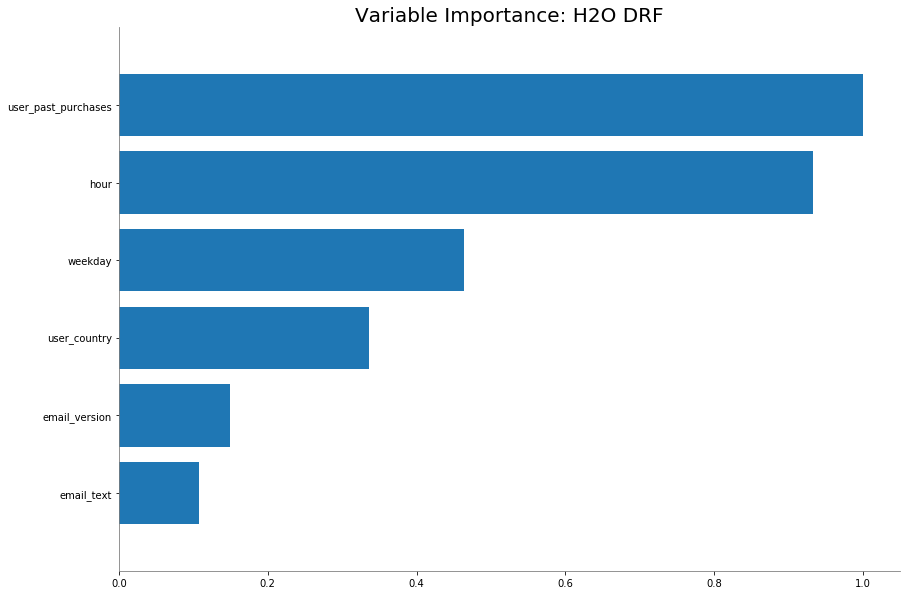

In [58]:
model.varimp_plot()


In [59]:
train_true = train.as_data_frame()['link_click'].values
test_true = test.as_data_frame()['link_click'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [61]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2500
           1       0.79      0.92      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.85      0.84      0.84      5000



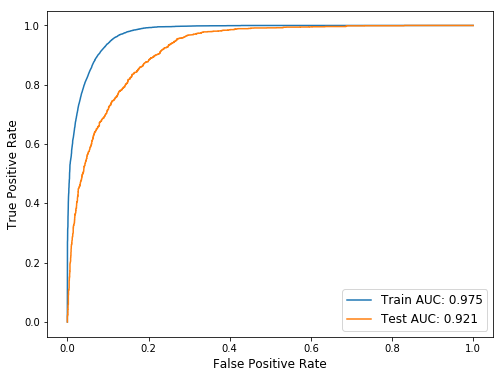

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

## Logistic Regression

In [67]:
glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic.train(x=feature, y= target, training_frame=train, model_id="glm_logistic")



glm Model Build progress: |███████████████████████████████████████████████| 100%


In [77]:
glm_logistic.coef()

{'Intercept': -1.3495557959117293,
 'hour.1': -0.03856086819216028,
 'hour.2': -0.24285880338087096,
 'hour.3': -0.14448195404419273,
 'hour.4': -0.30270028682838535,
 'hour.5': -0.028450932976821892,
 'hour.6': -0.08658613410442868,
 'hour.7': -0.0258325888676142,
 'hour.8': 0.08333535653116297,
 'hour.9': 0.2593583409223501,
 'hour.10': 0.22996511578876505,
 'hour.11': 0.31414900165410603,
 'hour.12': 0.20372910288828158,
 'hour.13': -0.016909052242660184,
 'hour.14': 0.00020482845905381644,
 'hour.15': 0.1993147987192578,
 'hour.16': 0.16645505221164802,
 'hour.17': -0.0074188627984662185,
 'hour.18': 0.0,
 'hour.19': 0.0,
 'hour.20': -0.8118048449199736,
 'hour.21': -0.06913650084039275,
 'hour.22': 0.0,
 'hour.23': 0.5336370083338334,
 'hour.24': 0.0,
 'weekday.Friday': -0.4867856971837783,
 'weekday.Monday': 0.06194833305622925,
 'weekday.Saturday': -0.22002016195348492,
 'weekday.Sunday': -0.3522589233265782,
 'weekday.Thursday': 0.2545023224296402,
 'weekday.Tuesday': 0.0890832

In [81]:
#glm_logistic.predict(test_data=test)

train_true = train.as_data_frame()['link_click'].values
test_true = test.as_data_frame()['link_click'].values
train_pred = glm_logistic.predict(train).as_data_frame()['p1'].values
test_pred = glm_logistic.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [82]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2500
           1       0.68      0.67      0.67      2500

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



In [84]:
print(glm_logistic.model_performance(test_data=test).rmse())
print(glm_logistic.model_performance(test_data=train).rmse())

0.4497829676216205
0.4512242552994131


In [86]:
print(glm_logistic.model_performance(test_data=test).r2())
print(glm_logistic.model_performance(test_data=train).r2())

0.19078112814995307
0.18558668571796022


## Logistic Regression other library

In [171]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
49970,182080,short_email,generic,7,Saturday,US,6,1.0,1.0
10844,892395,short_email,generic,10,Monday,ES,3,1.0,1.0
51497,206510,long_email,generic,6,Tuesday,US,5,1.0,1.0
43190,588030,short_email,personalized,12,Sunday,UK,9,1.0,1.0
45657,846155,short_email,generic,11,Tuesday,UK,10,1.0,1.0


In [226]:
log_data = data.copy()

In [227]:
log_data.shape

(20000, 9)

In [228]:
log_data['hour'] = log_data['hour'].apply(str)
#log_data['user_past_purchases'] = log_data['user_past_purchases'].apply(str)
#log_data['link_click'] = log_data['link_click'].apply(str)

In [229]:
del log_data['email_id']

In [230]:
cat_vars = log_data.select_dtypes(include=['object']).copy().columns  
for var in  cat_vars:
        log_data = pd.concat([log_data.drop(var, axis=1), pd.get_dummies(log_data[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
X = log_data.drop(['link_click','email_open'], axis=1)
X['constant'] = 1
y = log_data['link_click']

def create_Logit(X,y):
    '''
    creates statsmodels logistic regression model with 'linked click ' as target variable
    INPUT: pandas dataframe
    OUTPUT: statsmodels Logistic Regression model
    '''
    X = X.copy()
    X['constant'] = 1
    X.pop('email_id')
    logit = Logit(y,X)
    model = logit.fit(maxiter = 400)
    return model

from imblearn.over_sampling import SMOTE, RandomOverSampler
from statsmodels.discrete.discrete_model import Logit

random_over_sampler = RandomOverSampler()
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = .5, random_state = 1)
X_train_over_sample, y_train_over_sample= random_over_sampler.fit_sample(X_train,y_train)
X_train_over_sample = pd.DataFrame(X_train_over_sample)
X_train_over_sample.columns = X_train.columns
#model = create_Logit(X_train_over_sample,y_train_over_sample)
#print(model.summary(), '\n')

In [231]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.591260
         Iterations 6
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.147     
Dependent Variable:     link_click          AIC:                 23722.4058
Date:                   2021-01-05 14:52    BIC:                 24006.9314
No. Observations:       20000               Log-Likelihood:      -11825.   
Df Model:               35                  LL-Null:             -13863.   
Df Residuals:           19964               LLR p-value:         0.0000    
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         6.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
user_past_purchas

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


C:\Users\laura.liu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [244]:
y_pred = logreg.predict(X_test)


In [245]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68      3010
         1.0       0.68      0.67      0.67      2990

    accuracy                           0.68      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.68      0.68      0.68      6000



In [240]:
logreg.predict(X_train)

array([1., 0., 0., ..., 1., 1., 1.])

In [242]:
train_true = y_train.values
test_true = y_test.values
train_pred = logreg.predict(X_train)
test_pred = logreg.predict(X_test)

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

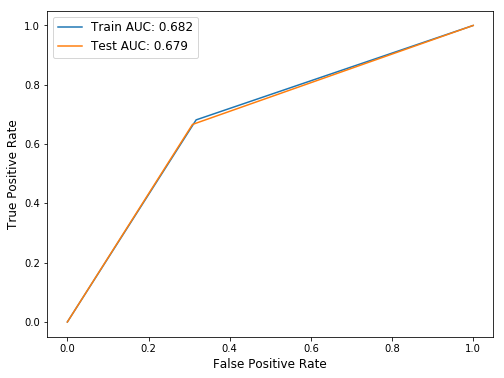

In [243]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

**<font color='blue'>Among those variable whose P values are below 0.05, we have variables:**
    * user_past_purchases         
    * email_text_short_email
    * email_version_personalized
    * all days exclude Friday 
    * user_country_UK
    * user_country_US     
    * hour_10
    * hour_11
    * hour_12
    * hour_15
    * hour_16
    * hour_20
    * hour_23
    * hour_9
   

**<font color='blue'>which hold positive coef., which means that they have positive impact on link_click</font>**

## Select postive impact variables in dataset

In [246]:
df_merge.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [247]:
df_merge['weekday'].unique()

array(['Sunday', 'Wednesday', 'Monday', 'Saturday', 'Friday', 'Tuesday',
       'Thursday'], dtype=object)

In [265]:
df_merge_change.shape

(5560, 9)

In [292]:
# exclude friday
df_merge_change = df_merge[df_merge['weekday'] != 'Friday']
#hours
df_merge_change = df_merge_change[df_merge_change['hour'].isin([10,11,12,15,16,20,23,9])]
#country
df_merge_change = df_merge_change[df_merge_change['user_country'].isin(['UK','US'])]
#user_past_purchase
df_merge_change = df_merge_change[df_merge_change['user_past_purchases']>0]
# email_text
df_merge_change = df_merge_change[df_merge_change['email_text']== 'short_email']
# email_version
df_merge_change = df_merge_change[df_merge_change['email_version']== 'personalized']

In [293]:
print("The updated strategy increase the conversion rate by" ,df_merge_change['link_click'].mean() - df_merge['link_click'].mean())

The updated strategy increase the conversion rate by 0.03312654676258993


## Run Hypothesis Test to see if it happened by chance

In [300]:
##split control group and test group
df_ctrl = df_merge
df_exp = df_merge_change

def expect_buyer_multiple(df, n):
    return [df.sample(frac=0.1, replace=False)['link_click'].mean() for i in range(n)]

exp_ctrl = expect_buyer_multiple(df_ctrl,3000)
exp_test = expect_buyer_multiple(df_exp,3000)


plt.figure(figsize=[20,10])
plt.hist(exp_ctrl,30, histtype='stepfilled', color='blue', alpha=0.50, label='ctrl')
plt.hist(exp_test,30, histtype='stepfilled', color='red', alpha=0.50, label='test')
plt.legend(loc='upper right', fontsize=30)
plt.xlabel('Expectation for email conversion rate', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text yticklabel objects>)

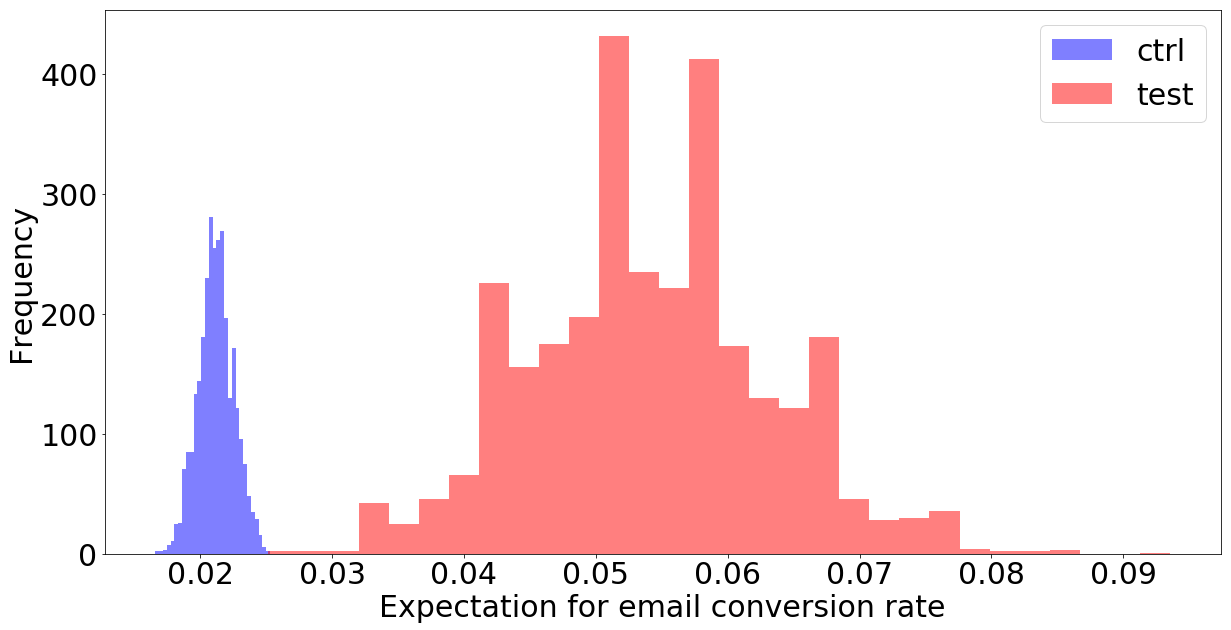

According to the calculation just now, the mean of test gropu is 3.3% higher than the control group. Now we need to run a hypythesis test to see if this 3.3% increase happens by chance.
* H0: Test <= Control
* H1: Test > Control

In [296]:
Ttest_indResult = stats.ttest_ind(df_exp['link_click'], df_ctrl['link_click'], axis=0, equal_var=True)

if Ttest_indResult.pvalue/2 > 0.05:
  print("fail to reject null H0")
elif Ttest_indResult.pvalue/2 <= 0.05:
  print("reject H0")

reject H0


## **<font color='blue'>According to the result of the A/B Testing, we reject the Null hypothesis in favor of accepting we do increase the conversion by the testing**